## 1. Loading and preparing the Dataset

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import keras

import warnings
warnings.filterwarnings("ignore")

#ref https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer

C:\Users\ramya\Anaconda3\envs\py3tf2\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
Using TensorFlow backend.


In [2]:

dataset,info = tfds.load('cifar10', as_supervised = True, with_info = True, batch_size = -1)
dataset_test, dataset_train = dataset['test'], dataset['train']


In [3]:
type(dataset)

dict

In [4]:
dataset_train[0][0].shape

TensorShape([32, 32, 3])

In [5]:
dataset_train[1].shape

TensorShape([50000])

In [6]:
dataset_test[0].shape

TensorShape([10000, 32, 32, 3])

In [7]:
dataset_test[1].shape

TensorShape([10000])

In [8]:
dataset_train[0][0][0][0]

<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([143,  96,  70], dtype=uint8)>

In [9]:
## check Data normalization

import numpy as np

train_x = dataset_train[0] / 255
train_y = dataset_train[1]
test_x = dataset_test[0] / 255
test_y = dataset_test[1]

In [10]:
train_x[0][0][0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.56078434, 0.3764706 , 0.27450982], dtype=float32)>

## Method -1, PrefetchDataset
Data Augmentation, Shuffling

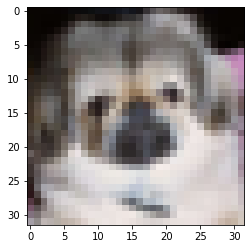

In [11]:
plt.imshow(train_x[100])

In [28]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, 0.2)

    image = tf.image.random_contrast(image, 1 / 1.3, 1.3)

    image = tf.image.random_hue(image, 0.1)

    image = tf.image.random_saturation(image, 1 / 1.2, 1.2)

    # Randomly increase the size of the image slightly to then randomly crop a part out of it.
    # This is a way to get random scales + translations
    random_height = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
    random_width = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
    image = tf.image.resize(image, (random_height, random_width))
    image = tf.image.random_crop(image, (32, 32, 3))

    return image,label

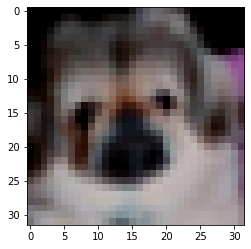

In [13]:
plt.imshow(augment(train_x[100],1)[0])

In [14]:
def normalize(image, label):
    """ Apply per image standardisation to normalize the image """
    return tf.image.per_image_standardization(image), label



In [15]:
def prepare_dataset(dataset, train=False, batch_size=512):
    """ Applies shuffling and augmentation (if train==True) + normalization and batching to the given dataset. """

    if train:
        # Shuffle the dataset with a buffer of 2048 and apply the augmentation
        # Prefetching adds an output buffer for the 16 augmentation threads
        dataset = dataset.shuffle(buffer_size=2048)
        dataset = dataset.map(augment, num_parallel_calls=16).prefetch(buffer_size=128)

    # normalize the images and batch them. Again add a buffer to prevent
    # unnecessary stopping of the batching or starvation of the GPU
    dataset = dataset.map(normalize, num_parallel_calls=8) \
        .batch(batch_size) \
        .prefetch(buffer_size=8)

    return dataset

In [16]:

# Load the test and training data as datasets with tensorflow_datasets
train_dataset = prepare_dataset(tfds.load(name="cifar10", split=tfds.Split.TRAIN, as_supervised=True), True)
test_dataset = prepare_dataset(tfds.load(name="cifar10", split=tfds.Split.TEST, as_supervised=True), False)


In [17]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [18]:
train_dataset.prefetch(100)

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>

In [16]:
# Define the model
model = tf.keras.models.Sequential([
    # As a further augmentation, apply a dropout
    tf.keras.layers.Dropout(0.1, input_shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(filters=96, kernel_size=3, activation='relu', padding='same'),  # (32, 32, 96)
    tf.keras.layers.Conv2D(filters=96, kernel_size=3, activation='relu', padding='same'),  # (32, 32, 96)
    tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=2, activation='relu', padding='same'),  # (16, 16, 96)
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(filters=192, kernel_size=3, activation='relu', padding='same'),  # (16, 16, 192)
    tf.keras.layers.Conv2D(filters=192, kernel_size=3, activation='relu', padding='same'),  # (16, 16, 192)
    tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=2, activation='relu', padding='same'),  # (8, 8, 192)
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(filters=192, kernel_size=3, activation='relu', padding='same'),  # (8, 8, 192)
    tf.keras.layers.Conv2D(filters=192, kernel_size=1, activation='relu', padding='same'),  # (8, 8, 192)
    tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=2, activation='relu', padding='same'),  # (8, 8, 192)

    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(filters=10, kernel_size=1, activation='relu', padding='same'),  # (8, 8, 10)

    tf.keras.layers.AveragePooling2D(pool_size=4, strides=4, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Activation('softmax')
])
# Print model summary
model.summary()

# Create callbacks for model saving and TensorBoard
cp_callback = tf.keras.callbacks.ModelCheckpoint('checkpoint.hdf5', verbose=1, save_weights_only=False)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Compile and run the model for 50 epochs
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[cp_callback, tb_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       3

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


     98/Unknown - 1879s 19s/step - loss: 2.2432 - accuracy: 0.1598
Epoch 00001: saving model to checkpoint.hdf5
98/98 [==============================] - 1978s 20s/step - loss: 2.2432 - accuracy: 0.1598 - val_loss: 45.5115 - val_accuracy: 0.1914
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 1.9900 - accuracy: 0.2712 
Epoch 00002: saving model to checkpoint.hdf5
98/98 [==============================] - 1964s 20s/step - loss: 1.9900 - accuracy: 0.2712 - val_loss: 82.0819 - val_accuracy: 0.3006
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 1.6433 - accuracy: 0.3957 
Epoch 00003: saving model to checkpoint.hdf5
98/98 [==============================] - 1961s 20s/step - loss: 1.6433 - accuracy: 0.3957 - val_loss: 82.6176 - val_accuracy: 0.3256
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 1.4459 - accuracy: 0.4727 
Epoch 00004: saving model to checkpoint.hdf5
98/98 [==============================] - 1983s 20s/step - loss: 1.445

## Method-2, EagerTensor

In [19]:
## check Data normalization

import numpy as np

train_x = dataset_train[0] / 255
train_y = dataset_train[1]
test_x = dataset_test[0] / 255
test_y = dataset_test[1]

In [20]:
train_x.shape[1:]

TensorShape([32, 32, 3])

In [21]:
type(train_x)

tensorflow.python.framework.ops.EagerTensor

In [22]:
batch_size = 64  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 50


### MODEL LAYOUT

In [23]:
model=Sequential()
model.add(Conv2D(32,(3,3),padding="same",input_shape=train_x.shape[1:]))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

If your targets are one-hot encoded, use categorical_crossentropy.
Examples of one-hot encodings:
[1,0,0]
[0,1,0]
[0,0,1]
But if your targets are integers, use sparse_categorical_crossentropy.
Examples of integer encodings (for the sake of completion):
1
2
3

In [25]:
# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
# ref https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_x)


#ref https://keras.io/api/preprocessing/image/
#ref https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer
# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(train_x, train_y, batch_size=32),validation_data=(test_x, test_y),
          steps_per_epoch=len(train_x) / 32, epochs=50)
                                                               


#or

# here's a more "manual" example
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= len(x_train) / 32:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

Epoch 1/50
1563/1562 [==============================] - 401s 256ms/step - loss: 1.8884 - accuracy: 0.2980 - val_loss: 2.1613 - val_accuracy: 0.1890
Epoch 2/50
1563/1562 [==============================] - 416s 266ms/step - loss: 1.6250 - accuracy: 0.4058 - val_loss: 2.5192 - val_accuracy: 0.1944
Epoch 3/50
1563/1562 [==============================] - 482s 309ms/step - loss: 1.5137 - accuracy: 0.4497 - val_loss: 2.7854 - val_accuracy: 0.1792
Epoch 4/50
1563/1562 [==============================] - 554s 354ms/step - loss: 1.4289 - accuracy: 0.4830 - val_loss: 2.6397 - val_accuracy: 0.1807
Epoch 5/50
1563/1562 [==============================] - 537s 343ms/step - loss: 1.3590 - accuracy: 0.5147 - val_loss: 2.4344 - val_accuracy: 0.2283
Epoch 6/50
1563/1562 [==============================] - 623s 399ms/step - loss: 1.3062 - accuracy: 0.5324 - val_loss: 2.7461 - val_accuracy: 0.2012
Epoch 7/50
1563/1562 [==============================] - 615s 394ms/step - loss: 1.2617 - accuracy: 0.5488 - val_

In [27]:
model.save("model.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


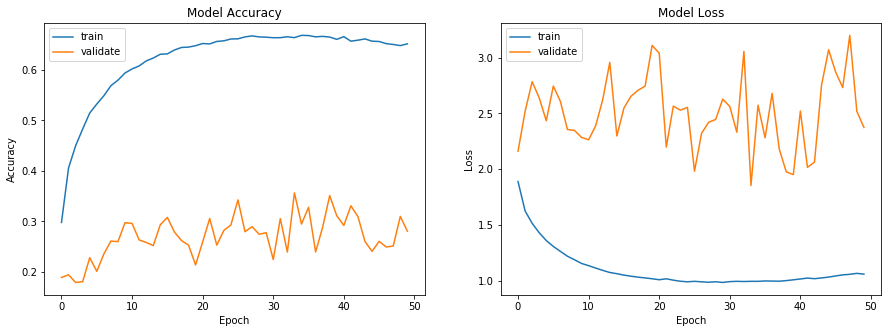

In [29]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history


plotmodelhistory(history)

In [30]:
type(history)

tensorflow.python.keras.callbacks.History

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [35]:
scores = model.evaluate(test_x, test_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(test_x)

313/313 [==============================] - 10s 33ms/step - loss: 2.3750 - accuracy: 0.2807
Test loss: 2.374985456466675
Test accuracy: 0.2806999981403351


In [42]:
pred

array([[0.15476131, 0.00240449, 0.5460079 , ..., 0.02380045, 0.0352175 ,
        0.00305145],
       [0.31655544, 0.0100426 , 0.21729004, ..., 0.06430921, 0.08141937,
        0.01400317],
       [0.01274054, 0.00078051, 0.32110888, ..., 0.02225094, 0.00474727,
        0.00177248],
       ...,
       [0.34647998, 0.00452078, 0.4013217 , ..., 0.00621199, 0.14343648,
        0.00532561],
       [0.10823467, 0.00456275, 0.48535433, ..., 0.02630161, 0.03599333,
        0.00645009],
       [0.23932311, 0.00750717, 0.347513  , ..., 0.02661885, 0.11748518,
        0.00938427]], dtype=float32)

In [43]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 



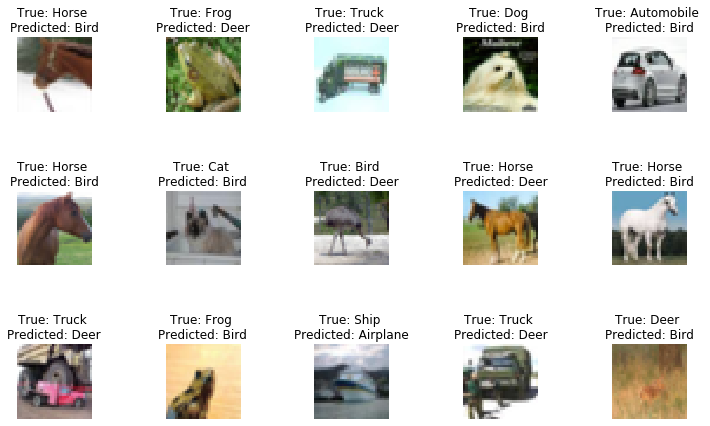

In [56]:
# Convert validation observations to one hot vectors
Y_true = test_y
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)



Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = test_x[errors]

R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(test_x[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)